### Imports

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import torch.nn.functional as F

from ucimlrepo import fetch_ucirepo

In [3]:
wine = fetch_ucirepo(id = 109)

In [4]:
wine_df = pd.concat([wine['data']['features'], wine['data']['targets']], axis = 1)
display(wine_df)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


weights and biases are joined within one matrix

In [5]:
# testing concat by columns
test_weights = torch.ones((4, 5))
display(test_weights)
test_biases = torch.zeros((4, 1))
display(test_biases)
test_concat = torch.concat([test_weights, test_biases], dim = 1)
display(test_concat)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

tensor([[0.],
        [0.],
        [0.],
        [0.]])

tensor([[1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.]])

In [6]:
# testing concat by rows
test_weights = torch.ones((3, 4))
display(test_weights)
test_biases = torch.zeros((2, 4))
display(test_biases)
test_concat = torch.concat([test_weights, test_biases], dim = 0)
display(test_concat)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [7]:
# testing stack by rows
test_weights = torch.ones((3, 4))
display(test_weights)
test_biases = torch.zeros((3, 4))
display(test_biases)
test_concat = torch.stack([test_weights, test_biases], dim = 0)
test_concat2 = torch.stack([test_weights, test_biases], dim = 2)
display(test_concat)
display(test_concat2)
display(test_concat2.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.]]])

torch.Size([3, 4, 2])

In [8]:
# testing matrix multiplication in pytorch

# assume 50 samples, 12 features and we include a bias term
X = torch.randn((50, 12))
bias_ones = torch.ones((X.shape[0], 1))

W = torch.randn((X.shape[1] + 1, 1))
X_aug = torch.concat([bias_ones, X], dim = 1)

display(X_aug.shape)
display(X_aug[:, 0])

y = X_aug @ W
display(y.shape)


torch.Size([50, 13])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

torch.Size([50, 1])

In [9]:
# testing out torch.softmax
yhat = torch.randn(10, 3)
display(yhat)
sftmx = torch.softmax(yhat, dim = 1)
display(sftmx)

# testing out conditionals for tensors
yprobs = torch.sigmoid(torch.randn(5, 1))
display(yprobs)
preds = (yprobs > 0.5).int()
display(preds)

test = torch.randn(10, 3)
display(test)
t = torch.argmax(test, dim = 1).reshape((-1, 1))
display(t)

tensor([[ 0.3367,  0.7381,  0.3688],
        [-0.8158, -1.2110, -0.0646],
        [-0.2331, -0.6181, -0.2049],
        [ 1.2227,  0.7453,  1.0940],
        [-0.4625, -0.4614,  0.4371],
        [-0.3441, -1.5400, -1.6377],
        [ 1.1933, -0.2313,  1.1195],
        [-0.7970, -0.6284,  0.4665],
        [ 0.2053,  0.6820, -0.3055],
        [ 1.7584,  0.9452,  0.2968]])

tensor([[0.2836, 0.4236, 0.2928],
        [0.2636, 0.1776, 0.5588],
        [0.3691, 0.2512, 0.3797],
        [0.4000, 0.2482, 0.3518],
        [0.2242, 0.2245, 0.5513],
        [0.6342, 0.1918, 0.1740],
        [0.4609, 0.1109, 0.4282],
        [0.1748, 0.2069, 0.6183],
        [0.3114, 0.5017, 0.1869],
        [0.5969, 0.2647, 0.1384]])

tensor([[0.1680],
        [0.5533],
        [0.2965],
        [0.7870],
        [0.3871]])

tensor([[0],
        [1],
        [0],
        [1],
        [0]], dtype=torch.int32)

tensor([[ 1.4283e-01,  7.0644e-02, -9.2761e-01],
        [-4.4385e-01, -1.0452e+00,  1.7570e+00],
        [-2.1093e+00, -1.3936e-01,  1.1101e+00],
        [-1.9729e+00,  7.8746e-02, -1.9189e+00],
        [-2.1834e+00, -8.9409e-01, -1.2794e+00],
        [-2.7853e-01, -5.0779e-01, -1.0752e+00],
        [-6.7065e-01, -3.2159e-01, -3.7462e-01],
        [-8.7484e-01,  9.5439e-01, -4.2372e-01],
        [ 1.9858e+00, -1.3812e+00,  6.1543e-01],
        [-7.0074e-04, -5.5860e-01,  6.8838e-02]])

tensor([[0],
        [2],
        [2],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [2]])

### Loss Functions and Grads

In [10]:
# def l2_loss(y_hat, y):
#     loss = torch.sum((y_hat - y)**2)
#     return loss

def l1_loss(y_hat, y):
    loss = torch.sum(torch.abs(y_hat - y))
    # print(loss)
    return loss

def l2_loss(y_hat, y):
    loss = torch.sum((y_hat - y)**2)

def ce_loss(y_hat, y):
    # initial definition
    loss = torch.sum(-y * torch.log(y_hat))

    # numerically stable CE
    # logits = torch.log(y_hat) - torch.log(y_hat - 1)
    # loss = torch.sum(-y * torch.log1p(logits))
    return loss


def get_l2_grad(X, y, y_hat):
    dW = (2/X.shape[0]) * (X.T @ (y-y_hat))
    db = (2/X.shape[0]) * torch.sum(y - y_hat)
    return dW, db

def get_bce_grad(X, y, y_hat):
    dW = X.T @ (y_hat - y)
    db = torch.mean(y_hat - y, dim = 0)
    return dW, db


def get_mce_grad(X, y, y_hat):
    dW = X.T @ (y_hat - y)
    db = torch.mean(y_hat - y, dim = 0)
    return dW, db

### Models

In [ ]:
class LinearRegression:
    def __init__(self, num_features, num_classes, loss_fn, get_grad):
        self.num_features = num_features
        self.num_classes = num_classes
        self.loss_fn = loss_fn
        self.get_grad = get_grad
        self.losses = []

        self.init_weights()

    def init_weights(self):
        self.W = torch.normal(0, 0.01, (self.num_features, self.num_classes), dtype = torch.float64)
        self.b = torch.zeros(self.num_classes, dtype = torch.float64)       # could try an array of biases to see if it helps

    def fit(self, X, y, epochs = 1000, lr = 0.01, loss_threshold = 1e-3):
        # enforce right dimensions
        assert X.shape[1] == self.num_features and y.shape[1] == self.num_classes
        self.losses = []
        
        # computes the gradient descent version of linear regression
        for t in range(epochs):
            y_hat = self.forward(X)
            loss = self.loss_fn(X, y)
            self.losses.append(loss)

            if loss < loss_threshold:
                break

            # compute gradient
            # dW = (2/X.shape[0]) * (X.T @ (y - y_hat))
            # db = (2/X.shape[0]) * torch.sum(y - y_hat)
            dW, db = self.get_grad(X, y, y_hat)

            # update features
            self.W = self.W - (lr * dW)
            self.b = self.b - (lr * db)


    def fit_OLS(self, X, y):
        assert X.shape[1] == self.num_features and y.shape[1] == self.num_classes

        # compute OLS solution
        W_OLS = torch.inverse(X.T @ X) @ X.T @ y
        b_OLS = torch.mean(y) - torch.mean(X @ W)
        self.W = W_OLS
        self.b = b_OLS

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        # assert X is of the shape (num_inputs, num_features)
        assert X.shape[1] == self.num_features
        return (X @ self.W) + self.b
    
    def predict_proba(self, X_val):
        return torch.sigmoid(self.forward(X_val)) \
            if self.num_classes == 1 \
                else torch.softmax(self.forward(X_val), dim = 1, dtype=float)
    def predict(self, X_val):
        # also split into 2 cases for binary- and multi- classification
        if self.num_classes == 1:
            # binary classification
            preds = self.predict_proba(X_val)
            return (preds > 0.5).int()
        else:
            # multiclassification
            preds = self.predict_proba(X_val)
            
            temp = torch.argmax(preds, dim = 1)
            return F.one_hot(temp, 3)
            
            # return torch.argmax(preds, dim = 1).reshape((-1, 1))    # could get rid of the reshape
            
    

In [ ]:
# testing out onehot
t3 = torch.rand(size = (10, 3))

preds = torch.argmax(t3, dim = 1)
display(t3)
display(preds)
onehot = F.one_hot(preds)
display(onehot)

True

tensor([[0.5893, 0.9630, 0.1672],
        [0.2473, 0.6283, 0.2154],
        [0.2119, 0.2089, 0.0885],
        [0.3891, 0.6106, 0.1434],
        [0.9929, 0.0338, 0.7202],
        [0.0353, 0.0556, 0.5071],
        [0.6691, 0.6719, 0.5604],
        [0.7017, 0.4409, 0.1602],
        [0.0807, 0.1582, 0.7449],
        [0.1742, 0.9487, 0.0088]])

tensor([1, 1, 0, 1, 0, 2, 1, 0, 2, 1])

tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]])

In [12]:
class LogisticRegression:

    def __init__(self, num_features, loss_fn, get_grad):
        self.num_features = num_features
        self.loss_fn = loss_fn
        self.get_grad = get_grad
        self.losses = []

        self.init_weights
    def init_weights(self):
        self.W = torch.normal(0, 1, size = (self.num_features, 1))
        self.b = 0.

    def fit(self, X, y, epochs = 1000, lr = 0.01, loss_threshold = 1e-3):
        assert X.shape[1] == self.num_features

        self.losses = []
        for epoch in epochs:
            y_hat = self.forward(X)

            # compute loss
            loss = self.loss_fn(y_hat, y)
            self.losses.append(loss)
            if loss < loss_threshold:
                break

            # compute gradient
            # dW = 2 * (X.T @ (y_hat - y)) / X.shape[0]
            # db = 2 * torch.sum(y_hat - y) / X.shape[0]
            dW, db = self.get_grad(X, y, y_hat)

            # update weights
            self.W = self.W - (lr * dW)
            self.b = self.b - (lr * db)

    def fit_OLS(self, X, y):
        
        W_OLS = torch.inverse(X.T @ X) @ X.T @ y
        b_OLS = torch.mean(y) - torch.mean(X @ W_OLS)

        self.W = W_OLS
        self.b = b_OLS

    def forward(self, X):
        return torch.sigmoid(X @ self.W + self.b)
    
    def __call__(self, X):
        return self.forward(X)
    
    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X):
        return (self.forward(X) > 0.5).int()
    
    def verify_grad(self, X, y, threshold):
        epsilon = 1e-5

        wd = self.W[0]
        w_minus_d = self.W[1:]
        wpos = wd + epsilon
        wneg = wd - epsilon

        approx_dw = (self.loss_fn(wpos, w_minus_d) - self.loss_fn(wneg, w_minus_d))/(2*epsilon)

        y_hat = self.forward(X)
        analytical_dw = self.get_grad(X, y, y_hat)

        result = ((analytical_dw - approx_dw)**2)/((analytical_dw + approx_dw)**2)

        return result < threshold

### Transform data

magnesium, ash and color intensity look like useless features

In [13]:
# normalize features
wine_std = wine_df.copy()
normalizer = StandardScaler()
onehot = OneHotEncoder()

wine_X = wine_df.drop(columns = ['class'])

wine_y = wine_df[['class']].copy()
wine_y = pd.get_dummies(wine_y['class'], dtype = float)

wine_X_std = normalizer.fit_transform(wine_X)

pcc_matrix = wine_X_std.T @ wine_y / wine_y.shape[0]
display(pcc_matrix)

,1,2,3
0,0.304677,-0.355686,0.051009
1,-0.096900,-0.144538,0.241438
2,0.107925,-0.177483,0.069558
3,-0.244617,0.089004,0.155613
4,0.153541,-0.145417,-0.008124
5,0.289485,-0.023162,-0.266324
6,0.317169,0.020654,-0.337823
7,-0.191911,0.005811,0.186100
8,0.179116,0.027523,-0.206639
9,0.067419,-0.340161,0.272742


<Figure size 1000x600 with 0 Axes>

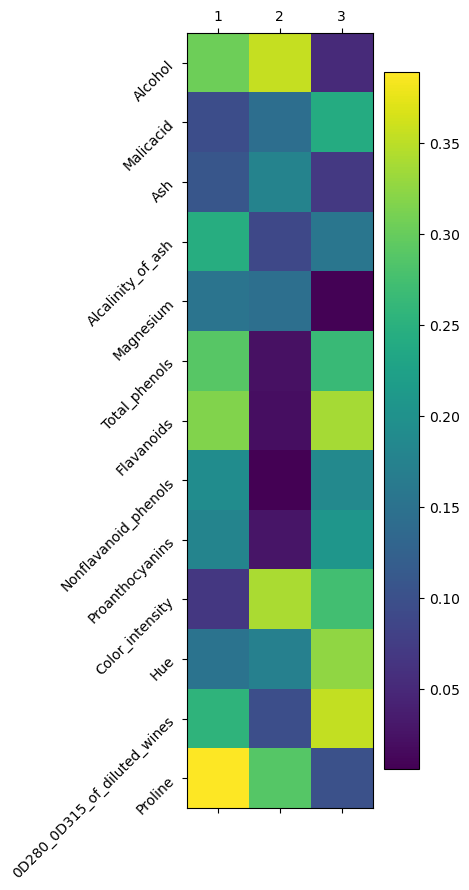

In [14]:
plt.figure(figsize = (10, 6))
plt.matshow(np.abs(pcc_matrix), aspect = 'auto')
plt.colorbar()
plt.yticks([i for i in range(wine_X_std.shape[1])], [i for i in wine_X.columns], rotation = 45)
plt.xticks([i for i in range(wine_y.shape[1])], [i for i in wine_y.columns])
fig = plt.gcf()
fig.set_size_inches(3, 10)

appears like all features at least have relevance to some class. if we had to remove, we could remove `ash` or `magnesium` or `nonflavanoid_phenols` if training time takes too long

<Figure size 1000x2000 with 0 Axes>

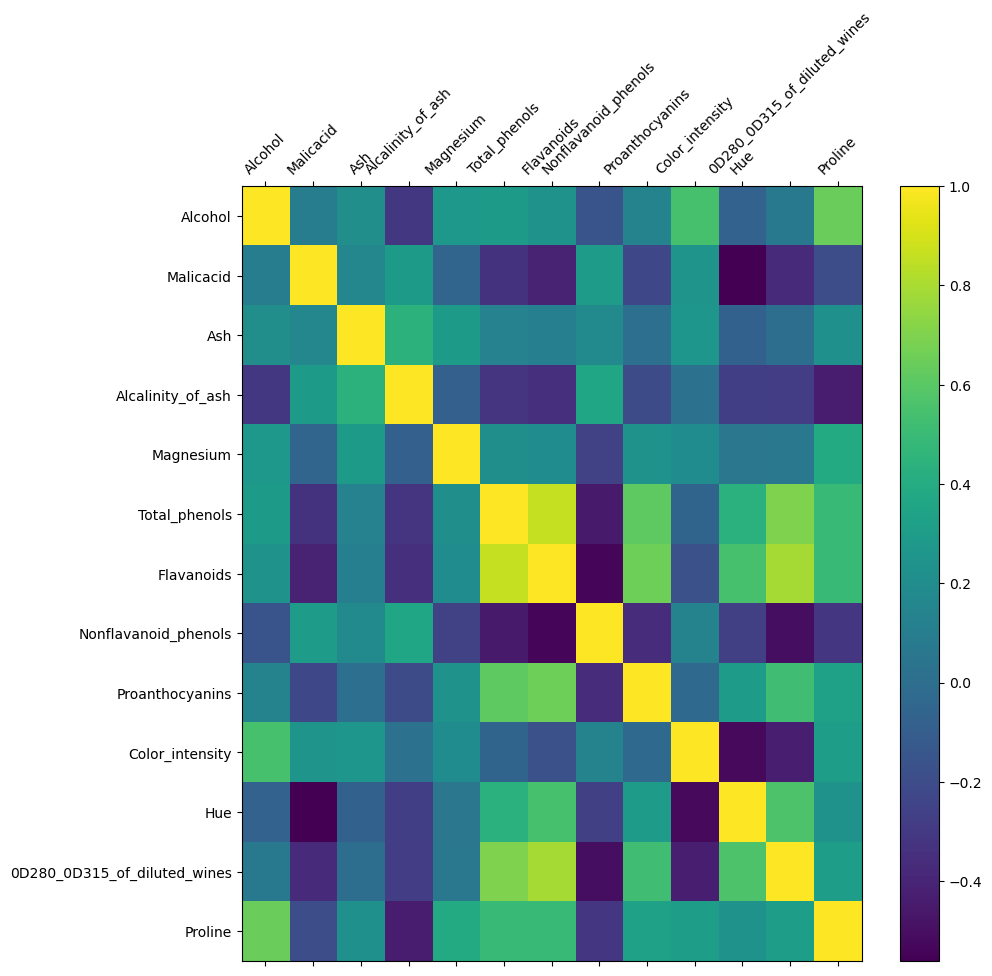

In [15]:
corr_wine_df = pd.DataFrame(wine_X_std).corr()
abs_corr_wine_df = np.abs(corr_wine_df)
plt.figure(figsize = (10, 20))
plt.matshow(corr_wine_df, aspect = 'auto')
plt.xticks([i for i in range(len(wine_X.columns))], [i for i in wine_X.columns], rotation = 45)
plt.yticks([i for i in range(len(wine_X.columns))], [i for i in wine_X.columns])
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(10, 10)

decent correlation between `flavanoids` and `total_phenols`, `flavanoids` and `0D280`, and `0d280` and `total_phenols`. so could remove one of them if training is slow

### Preprocessor

In [17]:
preproc = ColumnTransformer(
    transformers = [
        ('norm', StandardScaler, wine_X.columns),
    ], remainder = 'passthrough'
)

### Training Loop

In [58]:

LRClassifier = LinearRegression(13, 3, loss_fn = ce_loss, get_grad = get_mce_grad)

# constants
TEST_SIZE = 0.3
NUM_EPOCHS = 1000
NUM_FOLDS = 5

fold_accs = []

# split data 
X_train, X_test, y_train, y_test = train_test_split(wine_X, wine_y, test_size = TEST_SIZE, random_state = 0)


kf = KFold(n_splits = NUM_FOLDS, random_state = 0, shuffle = True)

for i, (train_ids, val_ids) in enumerate(kf.split(X_train, y_train)):
    
    infold_X = X_train.iloc[train_ids]
    infold_y = y_train.iloc[train_ids]
    display(type(X_train))
    display(type(y_train))
    
    # preprocess 
    infold_X_preproc = torch.Tensor(preproc.fit_transform(infold_X))
    infold_y = torch.Tensor(infold_y)

    # fit regression
    LRClassifier.fit(infold_X_preproc, infold_y, epochs = NUM_EPOCHS)
    
    # setup outfold data
    outfold_X = X_train.iloc[val_ids]
    outfold_y = y_train.iloc[val_ids]
    
    # preprocess
    outfold_X_preproc = torch.Tensor(preproc.fit_transform(outfold_X))
    
    
    # predict on outfold data
    preds = LRClassifier.predict(outfold_X_preproc)
    
    # calculate misclassification
    acc = np.sum([ 1 for i, j in zip(preds, outfold_y) if torch.equal(i, j)]) / preds.shape[0]
    
    fold_accs.append(acc)
    
display(np.mean(fold_accs))

plt.barh(
    [i for i in range(NUM_FOLDS)],
    fold_accs,
)

pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

In [55]:
t = torch.randint(0, 2, size = (10, 2))
t2 = torch.randint(0, 2, size = (10, 2))
matches = np.sum([ 1 for i, j in zip(t, t2) if torch.equal(i, j)])

display(t)
display(t2)
display(matches)

tensor([[0, 0],
        [1, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [0, 0],
        [1, 1]])

tensor([[1, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1]])

5